## Данные


В этой практической работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры и сравнивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Бонус ноутбука

Все исследователи данных знают, что SVM из библиотеки sklearn работает крайне медленно, поэтому на практике не могут его применять для решения задач.

В этом ноутбуке мы используем средства библиотеки sklearn intelex для ускорения обучения SVM в 600 раз! 

Ради интереса попробуйте после завершения выполнения заданий в ноутбуке удалить ячейки, связанные с установкой и импортом sklearn intelex и засечь время работы методов :)

In [ ]:
%%capture 
!pip install "scikit-learn-intelex<2021.5"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from matplotlib import pyplot as plt

import sys
import os
import site
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [ ]:
from sklearnex import patch_sklearn 

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Метрика качества

*  В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

Загрузим набор данных *data.adult.csv*.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/data.adult.csv")

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание** Найдите все признаки, имеющие пропущенные значения.

Затем удалите из выборки все объекты с пропусками.

In [ ]:
df.columns[df.isin(['?']).any()]

Index(['workclass', 'occupation'], dtype='object')

In [ ]:
print(df.shape)

df = df[df['workclass'] != '?']
df = df[df['occupation'] != '?']

print(df.shape)

(16280, 14)
(15347, 14)


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную y в отдельную переменную и преобразуйте к бинарному формату по правилу: '>50K' - 1, '<=50K' - 0.
 - Выделите матрицу объект-признак X, содержащую только вещественные столбцы (числовые) и не содержащую целевой переменной
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [ ]:
y = df['>50K,<=50K'].map({'>50K' : 1, '<=50K' : 0})

X = df[df.columns[df.dtypes != 'object']]

X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


**Задание:** сколько столбцов содержит матрица X?

Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Ответьте на этот вопрос для себя устно.

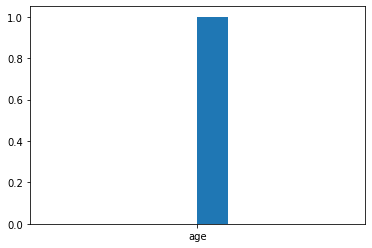

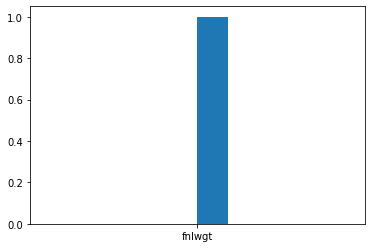

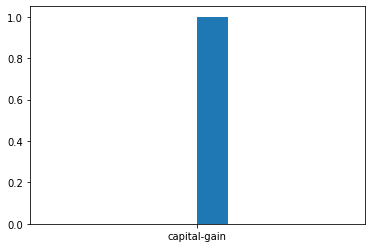

In [ ]:
plt.hist('age')
plt.show()

plt.hist('fnlwgt')
plt.show()

plt.hist('capital-gain')
plt.show()

Масштабируйте все вещественные признаки.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = pd.DataFrame(data = scaler.fit_transform(X), columns=X.columns)

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

# scaler.fit(Xtrain)

# Xtrain = pd.DataFrame(data = scaler.transform(Xtrain), columns=X.columns)
# Xtest = pd.DataFrame(data = scaler.transform(Xtest), columns=X.columns)

In [ ]:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

model = LogisticRegression()

model.fit(Xtrain, ytrain)

pred = model.predict_proba(Xtest)[:,1]

roc_auc_score(ytest, pred)

0.8175392698206339

In [ ]:
for i in range(len(Xtrain.columns)):
  print(i)
  print('mean:', Xtrain.mean()[i], Xtest.mean()[i])
  print('std:', Xtrain.std()[i], Xtest.std()[i])

0
mean: 38.4498696785404 38.63252541047694
std: 13.056666749163314 13.269720021720188
1
mean: 188071.7051259774 192402.73807662237
std: 105856.10723235317 107543.43936166988
2
mean: 10.162814943527367 10.114933541829554
std: 2.55455523268938 2.5485031238097555
3
mean: 1063.618158123371 1022.3247328642168
std: 7179.185710235962 6440.870520543345
4
mean: 88.37358818418767 89.54912692207454
std: 404.2956585766232 408.6199356640592
5
mean: 40.98653344917463 40.61011206671879
std: 11.970722360028653 12.207972826595046


In [ ]:
Xtest.mean()[0]

38.63252541047694

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

Сначала обучите по кросс-валидации c **тремя** фолдами и метрикой **roc_auc** алгоритмы:
*  LogisticRegression
*  SVC(kernel='linear')

Остальные параметры оставьте по умолчанию.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# пример для логистической регрессии

cross_val_score(LogisticRegression(), X, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


0.8290982075272866

In [ ]:
# посмотрите на среднее качество SVM с линейным ядром (SVM обучается очень долго!)

cross_val_score(SVC(kernel='linear', probability=True), X, y, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


0.8100354760945175

Теперь посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать два алгоритма:
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
У обоих алгоритмов будем оптимизировать гиперпараметр С, а у SVC - ещё гиперпараметр kernel.

*  Ищите C в диапазоне от 0.01 до 10.01 с шагом 0.25
*  Перебирайте ядра из списка ['rbf','poly','sigmoid','linear']

Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV (тут есть пример использования)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 3-fold cv.

In [ ]:
# подберите C у логистической регрессии

from sklearn.model_selection import GridSearchCV

params = {'C' : np.arange(0.01, 10.01, 0.25)}

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1) 

gs.fit(X, y)

gs.best_score_, gs.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


(0.8291469003150409, {'C': 0.26})

In [ ]:
# так как SVM работает долго, то:
# сначала первым gridsearch подберите у метода только kernel
# вторым gridsearch для найденного ядра подберите C в диапазане от 0.01 до 2.01 с шагом 0.25

params = {'kernel' : ['rbf','poly','sigmoid','linear']}

gs = GridSearchCV(SVC(), params, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)

gs.fit(X, y)

gs.best_score_, gs.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


(0.8100354760945175, {'kernel': 'linear'})

In [ ]:
params = {'C' : np.arange(0.01, 2.01, 0.25)}

gs = GridSearchCV(SVC(kernel='linear'), params, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)

gs.fit(X, y)

gs.best_score_, gs.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


(0.8117049223200672, {'C': 0.01})

**Задание:** Какой из алгоритмов имеет наилучшее качество? 

Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

*  Преобразуйте все категориальные признаки (исходной матрицы df) с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). Чтобы избежать переобучения, в get_dummies поставьте гиперпараметр **drop_first=True**.

*  Заново масштабируйте данные

In [ ]:
X_old = df.drop('>50K,<=50K', axis=1)

X_new = pd.get_dummies(X_old, drop_first=True)
X_new.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,34,284843,9,594,0,60,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
1,40,190290,10,0,0,40,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
2,36,177858,13,0,0,40,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
3,22,184756,10,0,0,30,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,47,149700,13,15024,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
scaler = StandardScaler()

X_new = pd.DataFrame(data = scaler.fit_transform(X_new), columns=X_new.columns)

Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

Обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 3-Fold CV в функции cross_val_score.

In [ ]:
#your code here

cross_val_score(LogisticRegression(C=0.26), X_new, y, cv=3, scoring='roc_auc').mean()

0.9053813801164657

In [ ]:
#your code here

cross_val_score(SVC(kernel='linear', C=0.01), X_new, y, cv=3, scoring='roc_auc').mean()

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

**Задание:** 
*  Разбейте данные на тренировочную и тестовую часть (либо данные только с числовыми признаками, либо данные после OneHot-кодировки - в зависимости от того, на каких данных модели лучше отработали). 

*test_size = 0.25, random_state = 42*

* Cреди всех обученных в работе моделей возьмите наилучшую (по roc-auc).
Заново обучите эту модель на тренировочных данных, сделайте предсказание на тесте.

* Постройте roc-кривую и отметьте на ней значение roc-auc - по тестовым данным.

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.25, random_state=42)

model = LogisticRegression(C=0.26)

model.fit(Xtrain, ytrain)

pred = model.predict_proba(Xtest)[:,1]

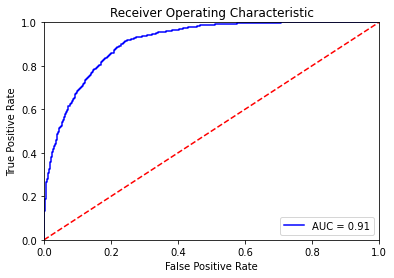

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(ytest, pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [ ]:
roc_auc

0.9103040405278424

**Задание:** чему равен roc-auc наилучшей модели на тестовых данных?